<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/main/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from patchify import patchify
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
from google.colab import files
import time
import re
from pathlib import Path

In [147]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Criando os patches

(patches já foram criados, não precisa rodar)

In [148]:
def create_image_patches(img_dir: str, patch_size: tuple[int, int, int], num_patches: int) -> None:
    """
    Creates patches from images in a given directory and saves them to a new directory.

    Args:
        img_dir (str): The path to the directory containing the images.
        patch_size (tuple): The desired size of each patch.
        num_patches (int): The number of patches to extract from each image.
    """
    # Create a new directory to store the patches
    patch_dir = os.path.join(img_dir, "patches")
    os.makedirs(patch_dir, exist_ok=True)

    # Loop through each image in the directory
    for img_name in os.listdir(img_dir):
        print('img_name =', img_name)

        try:
          # if the file is not an image then skip to next iteration
          if os.path.isdir(img_name):
            continue 

          # Load the image
          img_path = os.path.join(img_dir, img_name)
          img = np.array(Image.open(img_path))

          # Extract patches from the image using patchify
          patches = patchify(img, patch_size, step=patch_size[0])

          # Save the patches to the new directory
          img_patch_dir = os.path.join(patch_dir, f"{os.path.splitext(img_name)[0]}_patch")
          os.makedirs(img_patch_dir, exist_ok=True)

          for index, i in enumerate(range(patches.shape[0])):
              for j in range(patches.shape[1]):
                  if j == num_patches:
                    break

                  patch = patches[i, j, 0]
                  patch = Image.fromarray(patch)

                  save_path = os.path.join(img_patch_dir, f"patch_{j}.png")

                  patch.save(save_path)

        except IsADirectoryError:
          continue

In [149]:
%time
# demorou 2h 3m 0s para 2650 imagens
# create_image_patches('/content/gdrive/MyDrive/TCC/datasets/Flickr2K', (33, 33, 3), 10)
# create_image_patches('/content/gdrive/MyDrive/TCC/datasets/DIV2K_valid_HR', (33, 33, 3), 10)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


# ***SRCNN***

In [150]:
class SRCNN(nn.Module):
    def __init__(self) -> None:
        super(SRCNN, self).__init__()
        # 4.3 Model and Performance Trade-offs
        # Based on the basic network settings (i.e., f1 = 9, f2 = 1, f3 = 5, n1 = 64, and n2 = 32),
        f1 = 9
        f2 = 1
        f3 = 5
        n1 = 64
        n2 = 32

        self.model = nn.Sequential(
            # 3.1.1 Patch extraction and representation
            nn.Conv2d(in_channels=3, out_channels=n1,
                      kernel_size=(f1, f1), padding=(f1-1)//2),
            nn.ReLU(),

            # 3.1.2 Non-linear mapping
            nn.Conv2d(in_channels=n1, out_channels=n2,
                      kernel_size=(f2, f2), padding=(f2-1)//2),
            nn.ReLU(),

            # 3.1.3 Reconstruction
            nn.Conv2d(in_channels=n2, out_channels=3,
                      kernel_size=(f3, f3), padding=(f3-1)//2),
        )

        self._init_weights()

    def _init_weights(self):
      # The filter weights of each layer are initialized by drawing randomly 
      # from a Gaussian distribution with zero mean and standard deviation 0.001 (and 0 for biases)
      for module in self.modules():
        if isinstance(module, nn.Conv2d):
          module.weight.data.normal_(mean=0.0, std=0.001)
          if module.bias is not None:
              module.bias.data.zero_()

    def print_weights(self):
      for module in self.modules():
       if isinstance(module, nn.Conv2d):
          print(module.weight)

    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x


# Loops de **Treino** e Validação

In [151]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {validation_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


In [152]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [153]:
# garantir que é cuda
assert device == "cuda"

In [154]:
# Instancianting the model
model = SRCNN()
model.to(device)

# hyperparameters
lr = 1e-5

# CustomImageDataset

In [155]:
import os
from PIL import Image

def read_image_aux(file_path):
    """
    Reads and loads an image file from the specified path.

    Args:
        file_path (str): The path to the image file.

    Returns:
        PIL.Image.Image: The loaded image.
    """
    try:
        image = Image.open(file_path)
        return image
    except (IOError, OSError) as e:
        # Handle empty or corrupted files
        raise ValueError(f"Error loading image file: {file_path}. Reason: {str(e)}")

In [156]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        self.file_lst = self._create_file_list() if use_patches else list(os.listdir(img_dir))

    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return len(self.file_lst)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
        img_path = self.file_lst[idx]

        image = read_image(f"{self.img_dir}/{img_path}")
        image_x = image.detach().clone()
        image_y = image.detach().clone()

        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)

        return image_x.float() / 255, image_y.float() / 255

    def _create_file_list(self):
      """
      Creates a list of files to load, taking into account any patches that have been created.

      Returns:
          A list of file paths to load.
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      file_list = []
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          # checking if the image is an integral state
          file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

          if (file_size == 0):
            print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
            continue

          if self.patches_per_image and index == self.patches_per_image:
            break

          file_list.append(image_path)

      return file_list

# ImageHelper
Métodos auxiliares para exibir imagens

In [157]:
class ImageHelper:
    """
    A helper class for working with image data in PyTorch.
    """

    def __init__(self):
        """
        Initializes a new instance of the ImageHelper class.
        """
        return

    def show_tensor_as_image(self, tensor: torch.Tensor):
        """
        Displays an image represented as a PyTorch tensor.

        Args:
            tensor: A PyTorch tensor representing the image. The tensor should have shape (C, H, W),
                where C is the number of channels, H is the height, and W is the width.

        Returns:
            None
        """
        plt.figure()

        if torch.is_tensor(tensor):
          tensor_np = tensor.detach().numpy()
        else:
          tensor_np = tensor.numpy()
          
        plt.imshow(tensor_np.transpose((1, 2, 0)))
        plt.show()

ImageHelperInstance = ImageHelper()

# Criando os ***Dataset*'s**

In [158]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
])

transform_y = transforms.Compose([
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/Flickr2K", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir="/content/gdrive/MyDrive/TCC/datasets/DIV2K_valid_HR", transform=transform_x, target_transform=transform_y)

train_dataloader = DataLoader(train_data_set, batch_size=16, shuffle=True)
test_dataloader = DataLoader(validation_data_set, batch_size=16)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Training set has 26500 instances
Validation set has 1060 instances
CPU times: user 969 ms, sys: 1.15 s, total: 2.12 s
Wall time: 7.08 s


# Criando o *Optmizer* e a *loss function* (MSE)

In [159]:
# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()

# Exemplos de imagem de baixa e alta resolução do dataset de treino

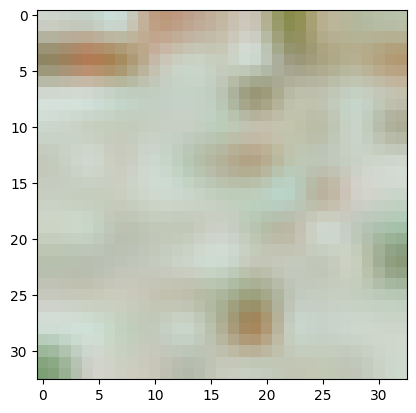

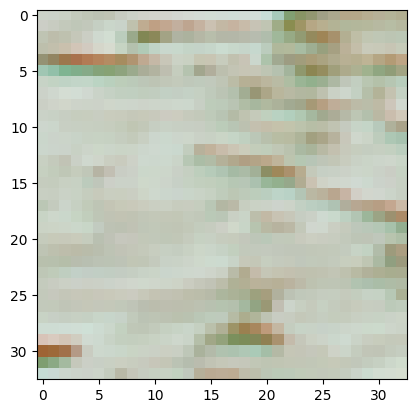

In [161]:
# example of training image
for X, y in train_dataloader:
    # print('X:')
    ImageHelperInstance.show_tensor_as_image(X[0])
    # print('y:')
    ImageHelperInstance.show_tensor_as_image(y[0])
    break


# Carregando o modelo

## Carregando a última *epoch* executada

- Função para pegar a epoch que paramos de executar na última sessão

In [162]:
def get_epoch_number_from_path(s: str) -> int or None:
    epoch_pattern = r"epoch=(\d+)"
    match = re.search(epoch_pattern, s)

    if match:
        epoch_number = int(match.group(1))
        return epoch_number
    else:
        return None

- Os arquivos estão sendo salvos no drive como no comando abaixo, a função `get_epoch_number_from_path` acima extrai o número da epoch através do nome do arquivo

In [163]:
os.listdir('/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models')

['2023-05-18_00:35:30_epoch=0_srcnn_avg_train_loss_0.25221318579637086_avg_validation_loss_0.15420054892698923',
 '2023-05-18_00:36:00_epoch=1_srcnn_avg_train_loss_0.2514351961704401_avg_validation_loss_0.15417732670903206',
 '2023-05-18_00:36:31_epoch=2_srcnn_avg_train_loss_0.24989220041495103_avg_validation_loss_0.15415425971150398',
 '2023-05-18_00:37:02_epoch=3_srcnn_avg_train_loss_0.2488373059492845_avg_validation_loss_0.15413117657105127',
 '2023-05-18_00:37:32_epoch=4_srcnn_avg_train_loss_0.2528951225372461_avg_validation_loss_0.15410792703429857',
 '2023-05-18_00:46:34_epoch=0_srcnn_avg_train_loss_0.24937577660267168_avg_validation_loss_0.15403849259018898',
 '2023-05-18_00:47:04_epoch=1_srcnn_avg_train_loss_0.2550358474254608_avg_validation_loss_0.15401514743765196',
 '2023-05-18_00:47:35_epoch=2_srcnn_avg_train_loss_0.250308381823393_avg_validation_loss_0.15399201959371567',
 '2023-05-18_00:48:06_epoch=3_srcnn_avg_train_loss_0.25209607298557574_avg_validation_loss_0.153968842

In [164]:
# finding the most recent epoch model
directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models'

most_recent_epoch = -1
model_load_path_name = ''
# model_load_path_name = f"{directory}/"
for filename in os.listdir(directory):
    epoch = get_epoch_number_from_path(filename)
    if epoch is not None and epoch > most_recent_epoch:
        most_recent_epoch = epoch
        model_load_path_name = os.path.join(directory, filename)

print("Most recent epoch:", most_recent_epoch)
print("Model load path name:", model_load_path_name)

Most recent epoch: 4
Model load path name: /content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models/2023-05-18_00:37:32_epoch=4_srcnn_avg_train_loss_0.2528951225372461_avg_validation_loss_0.15410792703429857


In [165]:
if not model_load_path_name:
  print('model_load_path_name does not exist. This a new training instance')
elif torch.cuda.is_available():
  model.load_state_dict(torch.load(model_load_path_name))
else:
  model.load_state_dict(torch.load(model_load_path_name, map_location=torch.device('cpu')))


# **Treinamento** 

## Salvando o Dataframe no drive e localmente para cada *epoch*

In [38]:
def download_df(df, train_loss, validation_loss, epoch):
  date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
  file_name = f'SRCNN_epoch={epoch}_{date}_srcnn_avg_train_loss_{train_loss}_avg_validation_loss_{validation_loss}.csv'
  df.to_csv(file_name)
  files.download(file_name)

Para executar o salvamento do Dataframe, lemos do drive o último .csv salvo, e adicionamos uma linha nele e salvamos novamente.

Obs: Para testes rápido com datasets pequenos, o tempo de leitura do dataframe no drive parece ser mais rápido que o tempo de escrita, o que gerava uma concorrência, para resolver isso, adicionei um `SLEEP_TIME` para esperar um tempo após cada escrita. 

In [100]:
SLEEP_TIME = 30

def save_df(df_path, train_loss, validation_loss, epoch, epoch_duration):
    # Check if the file exists
    if not os.path.isfile(df_path):
        df = pd.DataFrame({'Train Loss': [train_loss], 'Validation Loss': [validation_loss], 'epoch': [epoch], 'epoch_duration [s]': [epoch_duration]})
        download_df(df, train_loss, validation_loss, epoch) # for backup
        df.to_csv(df_path, index=False)
        time.sleep(SLEEP_TIME) # stop concurrency attempt
        return

    df = pd.read_csv(df_path)
    new_df_rows = {'Train Loss': [train_loss], 'Validation Loss': [validation_loss], 'epoch': [epoch], 'epoch_duration [s]': [epoch_duration]}
    df = df.append(pd.DataFrame(new_df_rows))
    download_df(df, train_loss, validation_loss, epoch) # for backup
    df.to_csv(df_path, index=False)
    time.sleep(SLEEP_TIME) # stop concurrency attempt
    

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [101]:
starting_epoch = get_epoch_number_from_path(model_load_path_name)
if starting_epoch is not None:
  starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of

print('starting_epoch =', starting_epoch)

starting_epoch = None


In [ ]:
%%time
train_loss = 0
validation_loss = 0
epochs = 15

train_loss_array = np.array([])
validation_loss_array = np.array([])
for index, t in enumerate(range(epochs)):
    # finding the current epoch number logic
    if index == 0 and starting_epoch is None:
      current_epoch = 0
      starting_epoch = 0
    elif starting_epoch >= 0:  
      current_epoch = starting_epoch + t
    else:
      current_epoch = 0

    print(f"\nEpoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    print('train_loss =', train_loss)
    validation_loss = validation_loop(test_dataloader, model, loss_fn)
    print('validation_loss =', validation_loss)
    
    train_loss_array = np.append(train_loss_array, train_loss)
    validation_loss_array = np.append(validation_loss_array, validation_loss)

    df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch

    print(f'elapsed_time for epoch {current_epoch} = {elapsed_time}')

    save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)

    # saving each epoch, since it's taking forever to train
    date = datetime.today().strftime('%Y-%m-%d %H:%M:%S').replace(' ', '_')
    model_save_path_name = f"{directory}/{date}_epoch={current_epoch}_srcnn_avg_train_loss_{train_loss}_avg_validation_loss_{validation_loss}"
    torch.save(model.state_dict(), model_save_path_name)
    
print("Done!")

# Train x Validation Loss


In [169]:
df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_4/SRCNN_train_vs_validation_loss.csv'

df = pd.read_csv(df_path)

In [170]:
df.head()

,Train Loss,Validation Loss,epoch
0,0.216251,0.185749,0
1,0.214914,0.184308,1
2,0.212921,0.182885,2
3,0.211220,0.181479,3
4,0.209583,0.180090,4


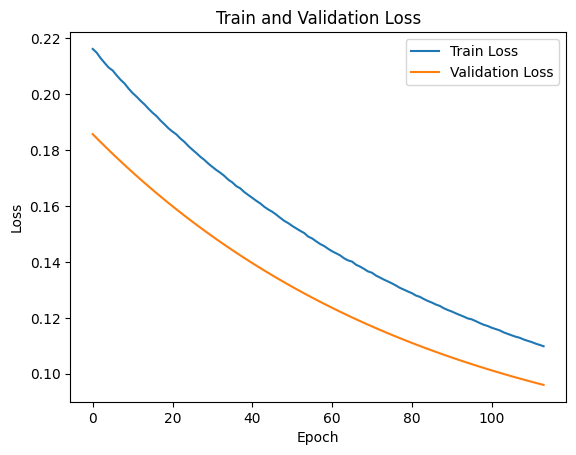

In [171]:
# Plotting the losses
plt.plot(df['epoch'], df['Train Loss'], label='Train Loss')
plt.plot(df['epoch'], df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Tesntando o modelo em uma imagem

torch.Size([3, 256, 256])
255


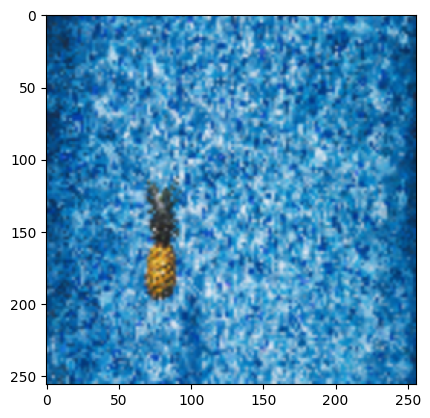

In [ ]:
new_image = Image.open('/content/gdrive/MyDrive/TCC/datasets/DIV2K_valid_HR/0797.png')
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
ImageHelperInstance.show_tensor_as_image(new_image_lr)


In [ ]:
new_image_lr.max()

tensor(0.9600)

In [ ]:
new_image_sr = model(new_image_lr.to(device))

In [ ]:
new_image_sr.max()

tensor(0.1980, device='cuda:0', grad_fn=<MaxBackward1>)

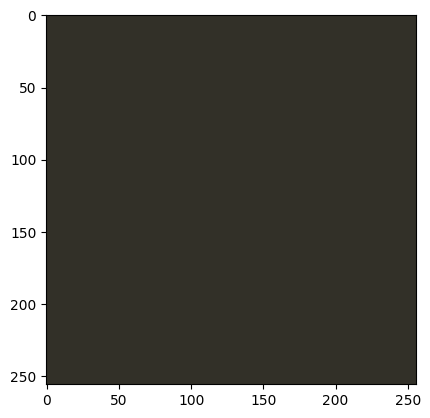

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr_np = new_image_sr.cpu().detach().numpy()
new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()